In [1]:
from motion_code import MotionCode
from data_processing import load_data, process_data_for_motion_codes

# In this example, we use ItalyPowerDemand dataset. First we load dataset include Y-values of the series and their labels
name = 'ItalyPowerDemand'
Y_train, labels_train = load_data(name=name, split='train')

# Then we process the data for motion code model and generate X-variable, which is needed for training.
X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)

# Now we load the test set
Y_test, labels_test = load_data(name=name, split='test')
X_test, Y_test, labels_test = process_data_for_motion_codes(Y_test, labels_test)

print(X_train.shape, Y_train.shape, labels_train.shape)
print(X_test.shape, Y_test.shape, labels_test.shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(67, 24) (67, 24) (67,)
(1029, 24) (1029, 24) (1029,)


In [2]:
# Next we build the default motion code model for both forecasting and classification
model = MotionCode(m=10, Q=1, latent_dim=2, sigma_y=0.1)

# Then we train model on the given X_train, Y_train, label_train set and saved it to a file named test_model.
model_path = 'saved_models/' + 'test_model'
model.fit(X_train, Y_train, labels_train, model_path)

In [3]:
import numpy as np

# Next we load the model and perform classification on 10 random test time series.
model.load(model_path)
num_test = labels_test.shape[0]
random_indices = np.random.choice(np.arange(num_test), size=10, replace=False)
predicted_labels = []
for ind in random_indices:
    predicted_labels.append(model.classify_predict(X_test[ind], Y_test[ind]))
print('True label:', list(labels_test[random_indices]))
print('Predicted label:', predicted_labels)

True label: [0, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Predicted label: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [4]:
# Now we can go on to perform prediction on the whole test set and get accuracy
acc = model.classify_predict_on_batches(X_test_list=X_test, Y_test_list=Y_test, true_labels=labels_test)
print('Accurary:', acc)

Accurary: 0.9115646258503401


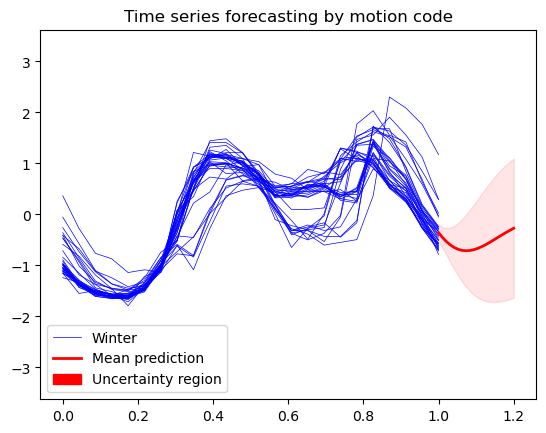

In [5]:
# Next we can use the same model to make prediction on a future interval.
# The X-variable in the previous cell is normalized to [0, 1]
# Note that the model make a average prediction over the whole collection of time series
# The prediciton is therefore made for the underlying stochastic process and not for the individual time series

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# We predict on test time horizon [1, 1.2] with 20 time steps
test_time_horizon = np.linspace(1, 1.2, 20)

# label is the label for the stochastic process we predict
mean, covar = model.forecast_predict(test_time_horizon, label=0)
std = np.sqrt(np.diag(covar)).reshape(-1)

# We plot all the time series on the horizon [0, 1]
X = X_train[labels_train==0, :]
Y = Y_train[labels_train==0, :]
plt.plot(X[0], Y[0], c='blue', lw=0.5, zorder=1, label='Winter')
for i in range(1, X.shape[0]):
    plt.plot(X[i], Y[i], c='blue', lw=0.5, zorder=1)

# Then we plot our prediction with uncertainty on test time horizon = [1, 1.2]
plt.plot(test_time_horizon, mean, c='red', lw=2, zorder=1, label='Mean prediction')
plt.fill_between(test_time_horizon, mean+2*std, mean-2*std, color='red', alpha=0.1, zorder=1)

# Plot setting and plot show
handle_list, _ = plt.gca().get_legend_handles_labels()
handle_list.append(mpatches.Patch(color='red', label='Uncertainty region'))
plt.legend(handles=handle_list, fontsize='10', loc ="lower left")
M = 1.1*max(np.max(np.abs(Y_train)), np.max(np.abs(Y_test)))
plt.ylim(-M, M)
plt.title('Time series forecasting by motion code')
plt.show()

In [7]:
# Now we already know how to use Motion Code. 
# Next we run Motion Code on 14 noisy data sets for classification tasks and report the accuracy.
# We already haved trained model, so you can load the model directly to save time.
datasets = ['Chinatown', 'ECGFiveDays', 'FreezerSmallTrain', 'GunPointOldVersusYoung', 'HouseTwenty', 'InsectEPGRegularTrain', 
            'ItalyPowerDemand', 'Lightning7', 'MoteStrain', 'PowerCons', 'SonyAIBORobotSurface2', 'Sound', 'Synthetic', 
            'UWaveGestureLibraryAll']

for name in datasets:
    # Load noisy data
    data_path = 'data/noisy/' + name
    data = np.load(data_path + '.npy', allow_pickle=True).item()
    Y_test, labels_test = data.get('X_test'), data.get('y_test')
    X_test, Y_test, labels_test = process_data_for_motion_codes(Y_test, labels_test)
    
    # Load existing model. You can train again if you want to.
    model_path = 'saved_models/' + name + '_classify'
    model.load(model_path)
    
    # Classify on batches and return accuracy
    acc = model.classify_predict_on_batches(X_test, Y_test, labels_test)
    print('Dataset %s has accurary %.2f %%.' % (name, acc*100))

Dataset Chinatown has accurary 66.47 %.


Dataset ECGFiveDays has accurary 66.55 %.


Dataset FreezerSmallTrain has accurary 70.25 %.


Dataset GunPointOldVersusYoung has accurary 91.11 %.


Dataset HouseTwenty has accurary 70.59 %.


Dataset InsectEPGRegularTrain has accurary 100.00 %.


Dataset ItalyPowerDemand has accurary 72.50 %.


Dataset Lightning7 has accurary 31.51 %.


Dataset MoteStrain has accurary 72.68 %.


Dataset PowerCons has accurary 92.78 %.


Dataset SonyAIBORobotSurface2 has accurary 75.97 %.


Dataset Sound has accurary 87.50 %.


Dataset Synthetic has accurary 100.00 %.


Dataset UWaveGestureLibraryAll has accurary 80.18 %.
